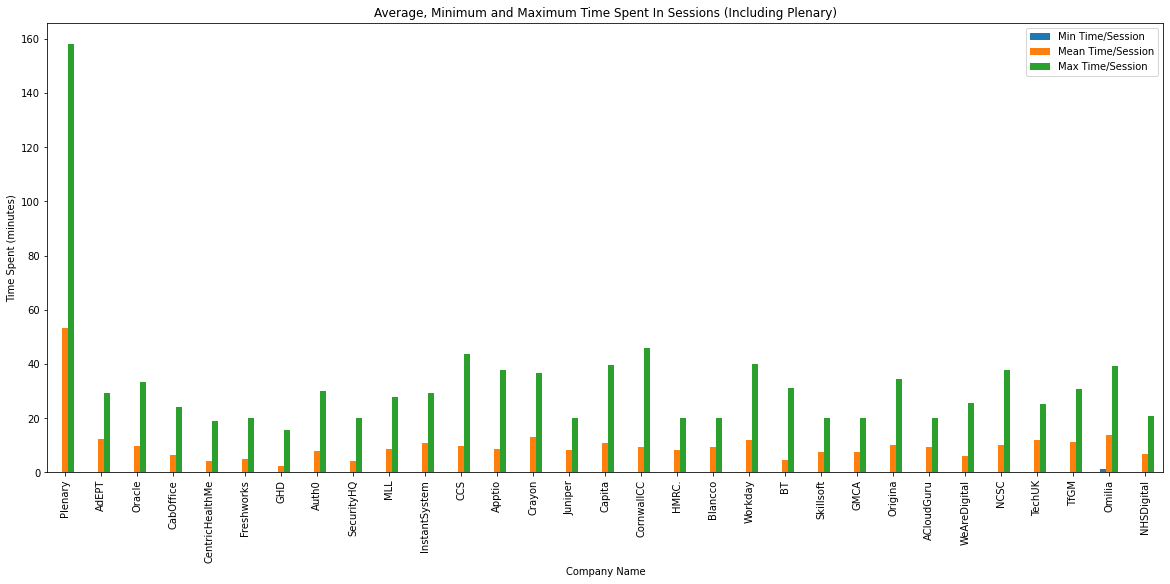

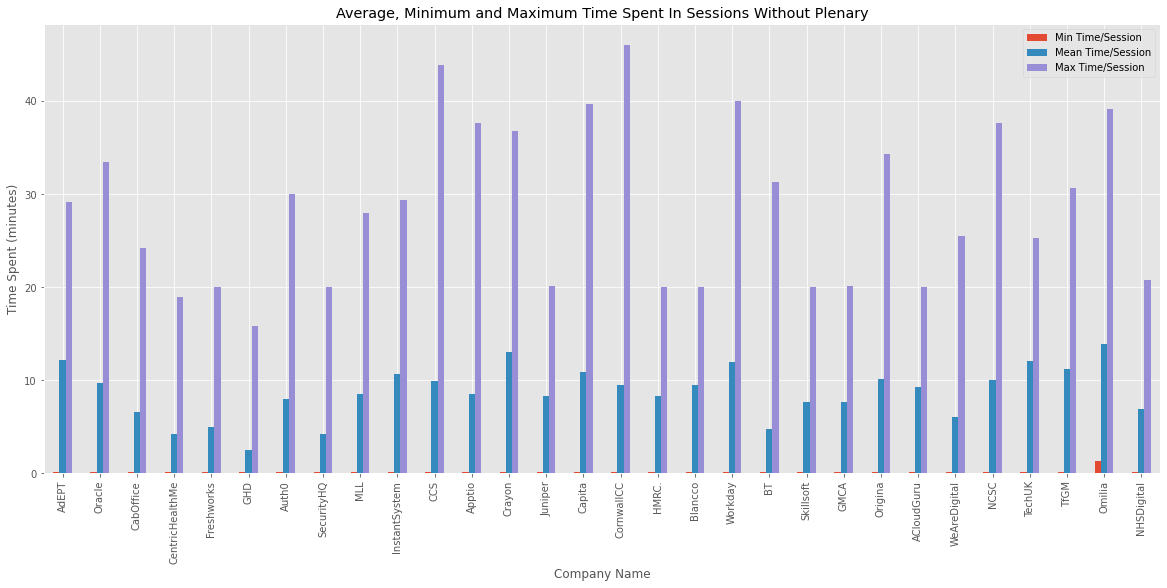

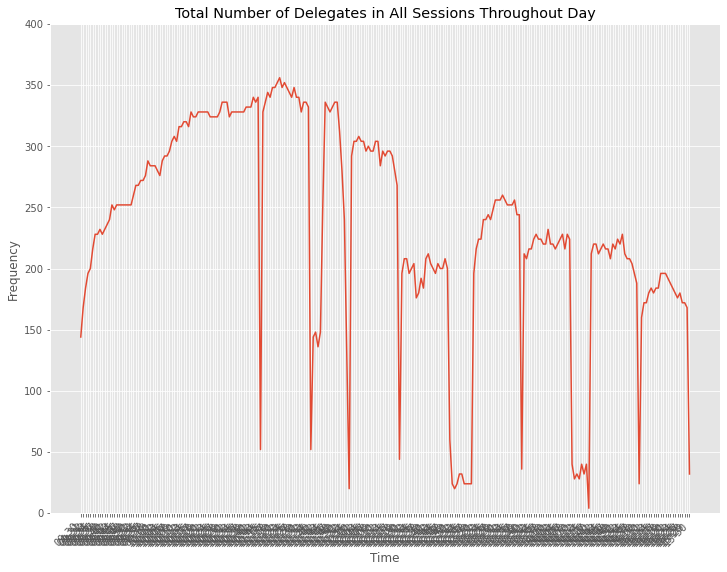

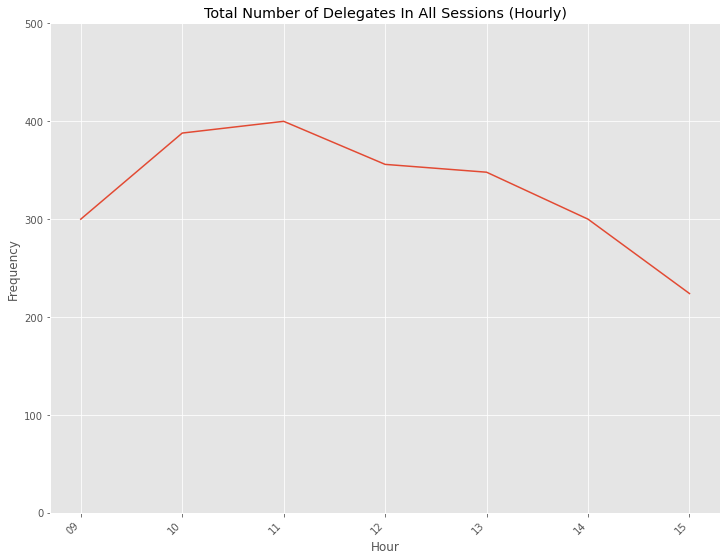

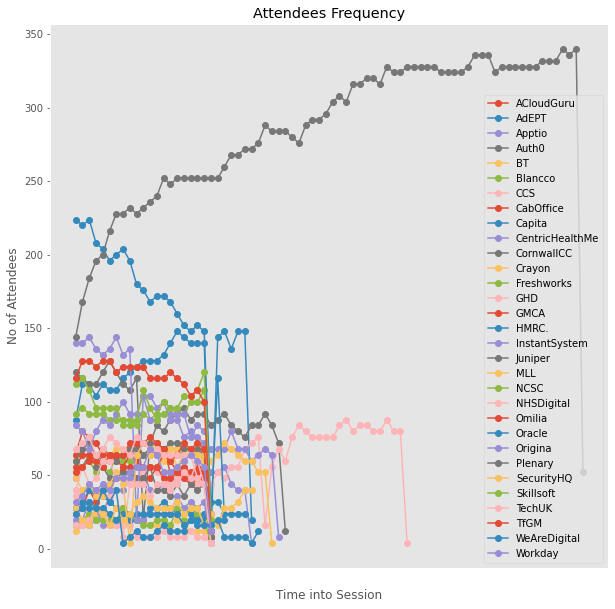

,attendee,Event Name,Start Time,End Time,Event Duration(min),Time Spent (min)
0,21209,Plenary Session,2021-12-09 09:30:00,2021-12-09 10:45:00,75,86.1667
1,21209,Fast tracking the backlog into business solutions (Demo),2021-12-09 11:15:00,2021-12-09 11:50:00,35,1.1667
2,21209,"The great balancing act: security, privacy and convenience",2021-12-09 12:00:00,2021-12-09 12:20:00,20,0.8333
3,21210,Plenary Session,2021-12-09 09:30:00,2021-12-09 10:45:00,75,86.1667
4,21210,Fast tracking the backlog into business solutions (Demo),2021-12-09 11:15:00,2021-12-09 11:50:00,35,1.1667
5,21210,"The great balancing act: security, privacy and convenience",2021-12-09 12:00:00,2021-12-09 12:20:00,20,0.8333
6,21211,Plenary Session,2021-12-09 09:30:00,2021-12-09 10:45:00,75,86.1667
7,21211,Fast tracking the backlog into business solutions (Demo),2021-12-09 11:15:00,2021-12-09 11:50:00,35,1.1667
8,21211,"The great balancing act: security, privacy and convenience",2021-12-09 12:00:00,2021-12-09 12:20:00,20,0.8333
9,21212,Plenary Session,2021-12-09 09:30:00,2021-12-09 10:45:00,75,86.1667


Maximum =  13 , Minimum =  1 , Mean =  1.8846153846153846 , Median =  1.0


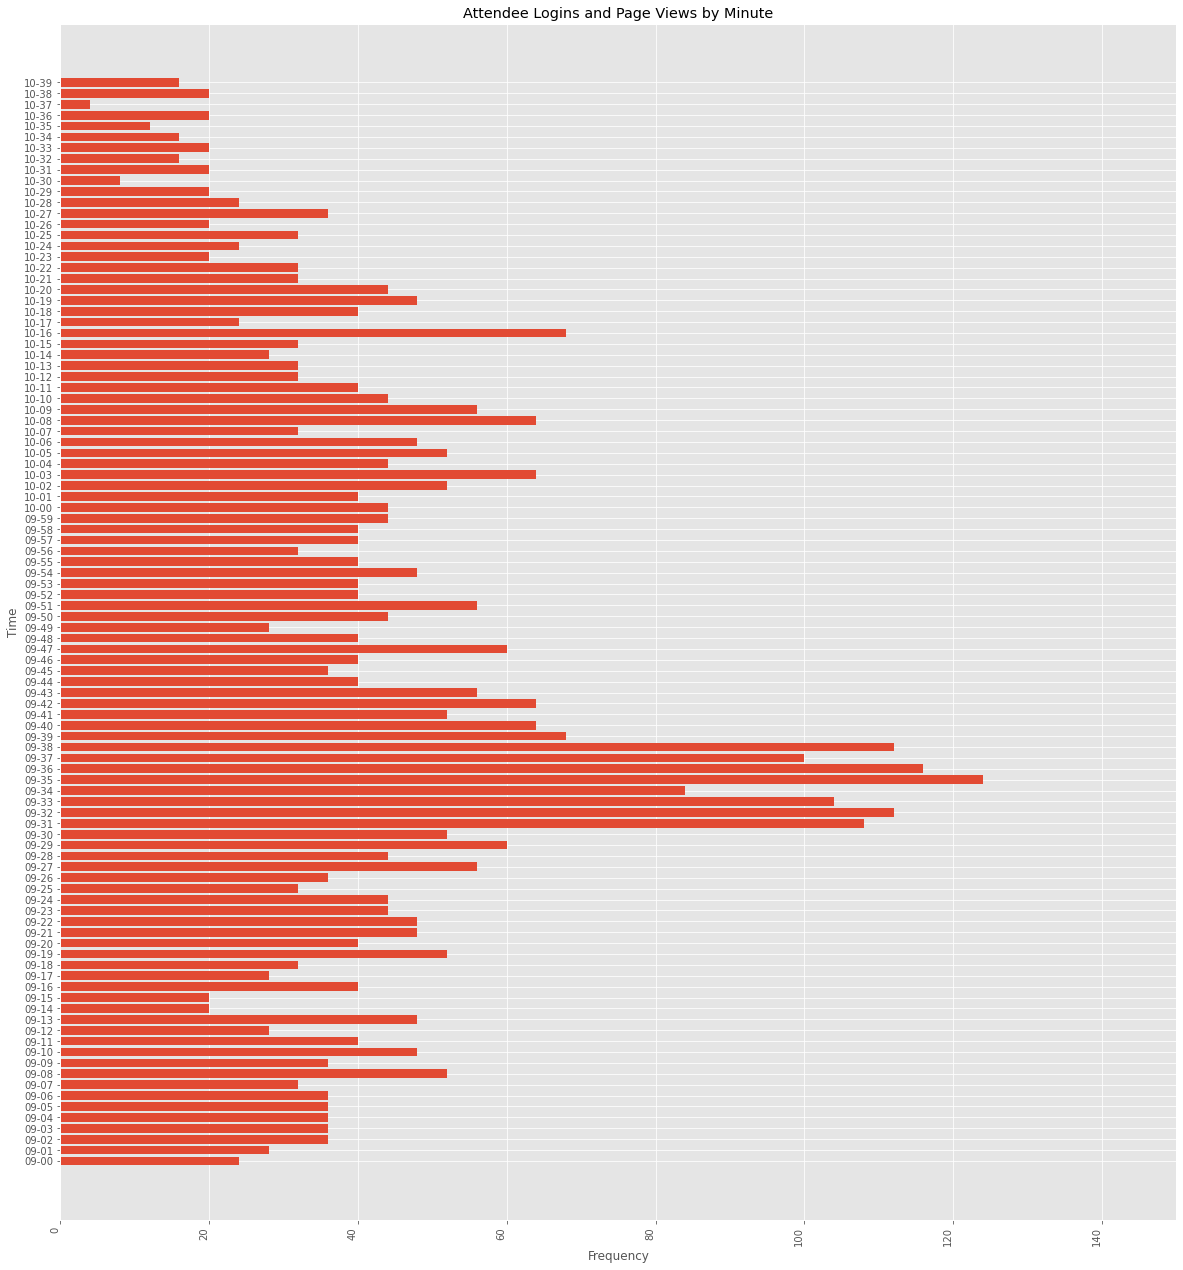

In [1]:
"""
        Visualization of when deligates attended. This is a bit tricky because the system only 
                                take note of the last log on time

         Anaylse how long they long on. This is tricky as well, the system takes snap shot every 6 times a mint. There is a need
        to check how long there snapshots were in order without breaking out and find average of each minutes

        Note: You are required to have preinstalled the needed third party libraries as stated in the documentation
"""
#Library importation
import matplotlib
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import dates as mdates
from matplotlib.ticker import NullFormatter  # useful for `logit` scale
from IPython.display import display, HTML
from datetime import datetime

#------display header/title ----------#
display(HTML("<h1 style='color:brown;text-align:center; font-size:40px;'>Duration Spent on Live session</h1><h3 style='color:blue;text-align:center; font-size:25px;'>When  delegates attended and how long did they attend for</h5>"))

#-----------Database connection & view preparation------------#
dbConnect=mysql.connector.connect(host="localhost",user="root",password="password",database="BookMeIn2", auth_plugin='mysql_native_password')
mycursor=dbConnect.cursor() 

sql="DROP VIEW IF EXISTS time_spent_view";
mycursor.execute(sql);
dbConnect.commit()

#Average Min, Max time spent
#------------- View Creation to aid select query ------#
mycursor.execute("CREATE VIEW time_spent_view AS SELECT attendee_session_tracking.attendeeid, events.event_reference, COUNT(attendee_session_tracking.date_pinged) AS pings FROM attendee_session_tracking INNER JOIN events ON events.id=attendee_session_tracking.eventid GROUP BY attendeeid, event_reference")

mycursor.execute("SELECT event_reference, MIN(pings)/6 AS 'Minimum Time Spent At Session (minutes)', AVG(pings)/6 AS 'Mean Time Spent at Session (minutes)', MAX(pings)/6 AS 'Maximum Time Spent at Session (minutes)' FROM time_spent_view GROUP BY event_reference")

output =  pd.DataFrame(mycursor.fetchall(), columns=['Company Name','Min Time/Session', 'Mean Time/Session','Max Time/Session'])

#convert output from object to double
output['Min Time/Session']=output['Min Time/Session'].astype(float)
output['Mean Time/Session']=output['Mean Time/Session'].astype(float)
output['Max Time/Session']=output['Max Time/Session'].astype(float)

#plot graph for  Average Min, Max time spent
output.plot(x='Company Name', kind='bar', stacked=False, title='Average, Minimum and Maximum Time Spent In Sessions (Including Plenary)', figsize=(20, 8.27))

matplotlib.style.use('ggplot')
plt.ylabel('Time Spent (minutes)')
plt.xticks( rotation=90, )
plt.show()

#Graph 1 Description
display(HTML("<p>Graph 1: This graph displays the maximum, minimum and mean time (in minutes) which was spent in each of the live sessions during the event. The minimum time spent in most sessions was under 1 minute, while the maximum time was at least the length of the session. For the Plenary Session, there were delegates who spent twice the session length in the session, i.e. they spent 157 minutes in a 75 minute session. This could be due to multiple users sharing a delegate account and viewing the session concurrently.  </p>"))

#Average Min, Max time spent WITHOUT PLENARY
#new seg
sql="DROP VIEW IF EXISTS plenary_view";
mycursor.execute(sql);
dbConnect.commit()

mycursor.execute("CREATE VIEW plenary_view AS SELECT attendee_session_tracking.attendeeid, events.event_reference, COUNT(attendee_session_tracking.date_pinged) AS pings FROM attendee_session_tracking INNER JOIN events ON events.id=attendee_session_tracking.eventid WHERE eventid != 4115 GROUP BY attendeeid, event_reference")

mycursor.execute("SELECT event_reference, MIN(pings)/6 AS 'Minimum Time Spent At Session (minutes)', AVG(pings)/6 AS 'Mean Time Spent at Session (minutes)', MAX(pings)/6 AS 'Maximum Time Spent at Session (minutes)' FROM plenary_view GROUP BY event_reference")

output =  pd.DataFrame(mycursor.fetchall(), columns=['Company Name','Min Time/Session', 'Mean Time/Session','Max Time/Session'])

#convert output from object to double
output['Min Time/Session']=output['Min Time/Session'].astype(float)
output['Mean Time/Session']=output['Mean Time/Session'].astype(float)
output['Max Time/Session']=output['Max Time/Session'].astype(float)

#plot graph for  Average Min, Max time spent
output.plot(x='Company Name', kind='bar', stacked=False, title='Average, Minimum and Maximum Time Spent In Sessions Without Plenary', figsize=(20, 8.27))
#plt.yscale('log')
plt.ylabel('Time Spent (minutes)')
plt.xticks( rotation=90, )
plt.show()

#Graph 2 Description
display(HTML("<p>Graph 2: This graph is as above, but without the Plenary Session included. This allows a clearer view of the data due to the reduction in range.</p>"))


#Total Attendees in Sessions
mycursor.execute("SELECT date_format(`date_pinged`,'%H-%i') AS formatted_date, count(DISTINCT `attendeeid`) as ping FROM attendee_session_tracking GROUP BY formatted_date")
hourly = pd.DataFrame(mycursor.fetchall(), columns=['formatted_date', 'ping'])

plt.figure(figsize=(12,9))
plt.plot(hourly['formatted_date'], hourly['ping'])
plt.ylim(0, 400)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Total Number of Delegates in All Sessions Throughout Day")
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right' )
plt.show()

#Graph 3 Description
display(HTML("<p>Graph 3: This graph shows the total number of delegates who were viewing a live session during any given minute during the conference. The graph starts at 9:30am and finishes at 3:30pm. The dips in traffic show times when sessions ended early, providing a gap before the start of the following session. Multiple sessions ended around 5-10 minutes early. It can be witnessed that the most visitors were present in sessions between 10am and 12pm, and as the day progressed fewer people visited the sessions. </p>"))



#----------Query for Total Number of Attendees in Sessions (Hourly) ----------#
mycursor.execute("SELECT date_format(`date_pinged`,'%H') AS formatted_date, count(DISTINCT `attendeeid`) as ping FROM attendee_session_tracking GROUP BY formatted_date")
hourly = pd.DataFrame(mycursor.fetchall(), columns=['formatted_date', 'ping'])

plt.figure(figsize=(12,9))
plt.plot(hourly['formatted_date'], hourly['ping'])
plt.ylim(0, 500)
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.title("Total Number of Delegates In All Sessions (Hourly)")
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right' )
plt.show()

#Graph 4 Description
display(HTML("<p>Graph 4: This gives the same information as the graph above, except that it is grouped by hour to provide a clearer x axis. The frequency at ‘9’ gives the number of unique delegates who visited one of the sessions between the time 9:00am and 9:59am.  </p>"))

#---------Query for Line Graph-----------#
mycursor.execute("SELECT eventid, event_reference, date_format(`date_pinged`,'%Y-%m-%d %H-%i') AS formatted_date, count(DISTINCT `attendeeid`) FROM attendee_session_tracking INNER JOIN events ON attendee_session_tracking.eventid=events.id GROUP BY eventid, formatted_date ORDER BY formatted_date") 

attendeeCount = pd.DataFrame(mycursor.fetchall(), columns=['Event ID', 'Event Name', 'Time', 'No Of Attendees'])



#Line Graph Plot function
def plot_line_graph(attendeeCount, Time, event_name, no_of_attendees, figsize=(2,2), title=None):
    #print(attendeeCount[Start_Date])
    fig, ax = plt.subplots(figsize=figsize)
    for key, grp in attendeeCount.groupby([event_name]):
        ax = grp.plot(ax=ax, kind='line', x=Time, y=no_of_attendees, label=key, marker='o')
    ax.autoscale_view()
    ax.legend(loc='lower right')
    _ = plt.xticks(color='w')
    _ = matplotlib.pyplot.tick_params(bottom=False)
    _ = plt.grid()
    _ = plt.xlabel('Time into Session')
    _ = plt.ylabel('No of Attendees')
    if title is not None:
        _ = plt.title(title)
    _ = plt.show()

#plot_line_graph function call
plot_line_graph(attendeeCount, 'Time', 'Event Name', 'No Of Attendees', figsize=(10, 10), title="Attendees Frequency")

#Graph 5 Description
display(HTML("<p>Graph 5: This graph shows the number of people active in each session in comparison to the time elapsed within the session. The longest line displays the way that traffic changed throughout the plenary session. The shorter the horizontal distance, the shorter the session. The lower the vertical height of the line, the less popular the session. The x axis time is from 0 minutes to 75 minutes. </p>"))

#------------- Query to fetch data to allow analysis & visualization ---------------#
mycursor.execute("SELECT attendeeid, name, start_time , end_time, TIMESTAMPDIFF(MINUTE,start_time, end_time) AS EventDuration , COUNT(DATE(date_pinged))/6 AS Time_spent_in_each_event FROM attendee_session_tracking A INNER JOIN events B ON A.eventid = B.id GROUP BY attendeeid, eventid, name ORDER BY attendeeid LIMIT 25") 
result = pd.DataFrame(mycursor.fetchall(), columns=['attendee','Event Name',  'Start Time', 'End Time', 'Event Duration(min)', 'Time Spent (min)']);

display(HTML("<br/><h3>Table Showing availble events and event time</h3>"))
display(HTML(result.to_html()))

#Table 1 Description
display(HTML("<p>Table 1: This table illustrates the start and end time of sessions, as well as the event duration and the comparative time that a given delegate spent in the session. This has been limited to 25 results to give a small sample of the data. </p>"))

#------------ Number of Times Each Attendee Logged On -------------------#
display(HTML("<br/><h3>Number of times each Attendee Logged on</h3>"))

mycursor.execute("SELECT `attendeeid`, COUNT(*) FROM `attendee_log` WHERE `date_visited` BETWEEN '2021-12-09 00:00:00' AND '2021-12-10 00:00:00' AND `reftype`='login' GROUP BY `attendeeid`") 
loginresult = pd.DataFrame(mycursor.fetchall(), columns=[ 'attendee ID', 'login_times']);
maxLogin = loginresult['login_times'].max(), loginresult['login_times'].min(), loginresult['login_times'].mean(), loginresult['login_times'].median()
display(HTML('<b>Maximum, Minimum, Mean and Median number of login(s)</b>'))
print ('Maximum = ', maxLogin[0], ', Minimum = ', maxLogin[1], ', Mean = ', maxLogin[2], ', Median = ', maxLogin[3])

#Query Description
display(HTML("<p>Max/Min/Mean/Median Query: This shows the maximum, minimum, mean and median number of logins made by the delegates in attendance of the online event. </p>"))

#------------ Number of Times Each Attendee Logged On -------------------#
#Start
mycursor.execute("SELECT date_format(`date_visited`,'%H-%i') AS formatted_date, count(DISTINCT attendeeid) FROM attendee_log WHERE `date_visited` BETWEEN '2021-12-09 09:00:00' AND '2021-12-09 15:30:00' GROUP BY formatted_date LIMIT 100")
loginclicked = pd.DataFrame(mycursor.fetchall(), columns=['time', 'count']);
matplotlib.style.use('ggplot')
plt.figure(figsize=(20,22))
plt.barh(loginclicked['time'], loginclicked['count'])
plt.xlim(0, 150)
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.title("Attendee Logins and Page Views by Minute")
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

#Graph 6 Description
display(HTML("<p>Graph 6: This graph shows the number of logins and page clicks which occurred during any given minute throughout the conference. This is limited to 100 minutes to give an illustration of the traffic flow.  </p>"))


#----------Footer Section for report generation navigation -----------------#
footer = "<div style='width:100%; text-align:center;'><a href='2-event-mode-analysis.html' style='color:blue;'>Previous</a> <a href='4-virtual-and-after-event-viewer.html' style='color:blue;'>Next</a></div>"
display(HTML(footer))
